# **Task 4: Loan Default Prediction**
**Objective:** Build a classification model to predict whether a loan applicant will default using
financial data.

● **Dataset:** Lending Club Loan Dataset

● **Steps:**
1. Preprocess the data, handling missing values and class imbalance using
techniques like SMOTE.
2. Train classifiers such as LightGBM or SVM.
3. Evaluate performance using metrics such as Precision, Recall, and F1 Score.
4. Generate a comprehensive performance report and recommendations for
lenders.

● **Outcome:** A classification model to identify high-risk loan
applicants, helping reduce defaults.

# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import lightgbm as lgb
from sklearn.svm import SVC
import warnings

warnings.filterwarnings('ignore')



# **Load Dataset**

Loan.csv

In [ ]:
import pandas as pd
df = pd.read_csv('loan.csv')
print(df.head())

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0   

#**1. Preprocess the data**
Preprocess the data, handling missing values and class imbalance using
techniques like SMOTE.

In [ ]:

# Target Variable: 'Loan_Status' (Y for Approved/Non-Default, N for Rejected/Default)
# We want to predict 'Default', so map 'N' to 1 (Default) and 'Y' to 0 (Non-Default).

df['is_default'] = df['Loan_Status'].map({'N': 1, 'Y': 0})
df = df.drop('Loan_Status', axis=1) # Drop original target column

print("\nDefault Distribution after target mapping:")
print(df['is_default'].value_counts())
print(f"Default Rate: {df['is_default'].mean()*100:.2f}%")

# Drop 'Loan_ID' as it's just an identifier and not a predictive feature
df = df.drop('Loan_ID', axis=1)



Default Distribution after target mapping:
is_default
0    422
1    192
Name: count, dtype: int64
Default Rate: 31.27%


In [ ]:

# Separate features (X) and target (y)
X = df.drop('is_default', axis=1)
y = df['is_default']

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"\nNumerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Preprocessing Pipeline setup
# For numerical features: impute NaNs with mean, then scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# For categorical features: impute NaNs with most frequent, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Common for categorical NaNs
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep any other columns (e.g., if any unexpected ones)
)



Numerical features: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical features: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


In [ ]:

# --- 3. Split Data and Handle Class Imbalance with SMOTE ---
# Split data BEFORE applying SMOTE to prevent data leakage from test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nOriginal Training Set Default Distribution:\n{y_train.value_counts()}")



Original Training Set Default Distribution:
is_default
0    337
1    154
Name: count, dtype: int64


# **Train classifiers such as LightGBM or SVM.**


--- Training Classifiers ---

--- LightGBM Model ---
[LightGBM] [Info] Number of positive: 337, number of negative: 337
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 674, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


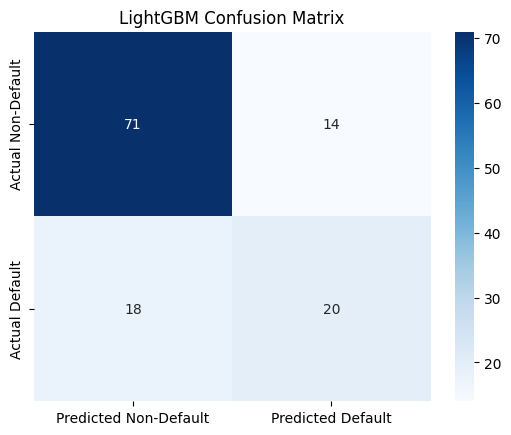

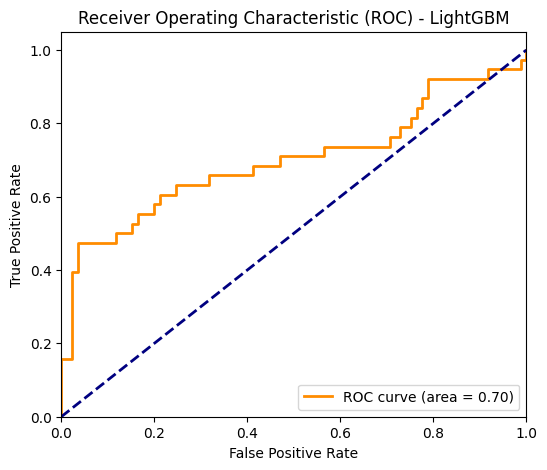

In [ ]:
# --- 4. Train Classifiers ---
print("\n--- Training Classifiers ---")

# --- LightGBM Classifier ---
print("\n--- LightGBM Model ---")
# Use Imblearn's Pipeline to ensure SMOTE is applied correctly on preprocessed data
lgbm_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=5)),
    ('classifier', lgb.LGBMClassifier(random_state=42, class_weight='balanced'))
])

# LightGBM Hyperparameter Tuning (Grid Search)
lgbm_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__num_leaves': [20, 31],
    'classifier__max_depth': [5, 10],
}
# Use StratifiedKFold for cross-validation to maintain class balance in folds
lgbm_grid_search = GridSearchCV(lgbm_pipeline, lgbm_param_grid, cv=StratifiedKFold(3), scoring='f1', n_jobs=-1, verbose=0)
lgbm_grid_search.fit(X_train, y_train)

print(f"\nBest parameters for LightGBM: {lgbm_grid_search.best_params_}")
print(f"Best cross-validation F1 score for LightGBM: {lgbm_grid_search.best_score_:.4f}")

y_pred_lgbm = lgbm_grid_search.predict(X_test)
y_proba_lgbm = lgbm_grid_search.predict_proba(X_test)[:, 1]

print("\nLightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

print("\nLightGBM Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_lgbm), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Default', 'Predicted Default'],
            yticklabels=['Actual Non-Default', 'Actual Default'])
plt.title('LightGBM Confusion Matrix')
plt.show()

# ROC Curve for LightGBM
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_proba_lgbm)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)
plt.figure(figsize=(6, 5))
plt.plot(fpr_lgbm, tpr_lgbm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lgbm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - LightGBM')
plt.legend(loc="lower right")
plt.show()




--- SVM Model ---

Best parameters for SVM: {'classifier__C': 0.1, 'classifier__kernel': 'rbf'}
Best cross-validation F1 score for SVM: 0.5955

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86        85
           1       0.75      0.47      0.58        38

    accuracy                           0.79       123
   macro avg       0.77      0.70      0.72       123
weighted avg       0.78      0.79      0.77       123


SVM Confusion Matrix:


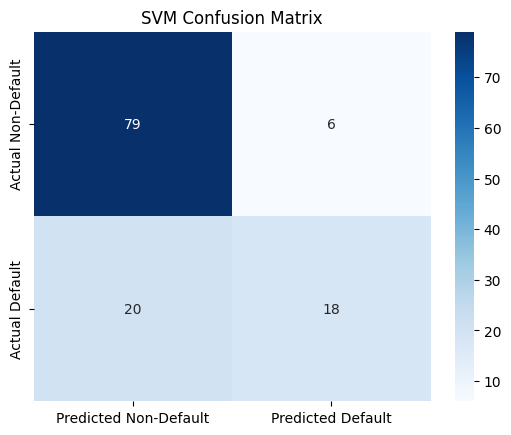

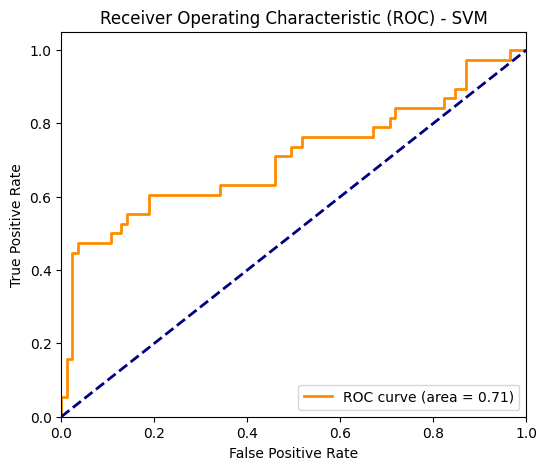

In [ ]:

# --- SVM Classifier ---
# NOTE: SVM can be very slow on larger datasets. For this smaller dataset, it should be manageable.
print("\n--- SVM Model ---")
svm_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=5)),
    ('classifier', SVC(probability=True, random_state=42, class_weight='balanced')) # probability=True for predict_proba
])

# SVM Hyperparameter Tuning (simplified for speed)
svm_param_grid = {
    'classifier__C': [0.1, 1], # Regularization parameter
    'classifier__kernel': ['linear', 'rbf'] # Kernel type
}

try:
    svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=StratifiedKFold(3), scoring='f1', n_jobs=-1, verbose=0)
    svm_grid_search.fit(X_train, y_train)

    print(f"\nBest parameters for SVM: {svm_grid_search.best_params_}")
    print(f"Best cross-validation F1 score for SVM: {svm_grid_search.best_score_:.4f}")

    y_pred_svm = svm_grid_search.predict(X_test)
    y_proba_svm = svm_grid_search.predict_proba(X_test)[:, 1]

    print("\nSVM Classification Report:")
    print(classification_report(y_test, y_pred_svm))

    print("\nSVM Confusion Matrix:")
    sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Non-Default', 'Predicted Default'],
                yticklabels=['Actual Non-Default', 'Actual Default'])
    plt.title('SVM Confusion Matrix')
    plt.show()

    fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svm:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - SVM')
    plt.legend(loc="lower right")
    plt.show()

except Exception as e:
    print(f"\nSkipping SVM due to error or performance issue: {e}")
    y_pred_svm = None
    y_proba_svm = None
    roc_auc_svm = None


# **Evaluate performance using metrics such as Precision, Recall, and F1 Score.**

In [ ]:

# --- 5. Generate a comprehensive performance report and recommendations ---
print("\n--- Comprehensive Performance Report & Recommendations ---")

# Calculate metrics for LightGBM
lgbm_precision = precision_score(y_test, y_pred_lgbm)
lgbm_recall = recall_score(y_test, y_pred_lgbm)
lgbm_f1 = f1_score(y_test, y_pred_lgbm)

print("\n--- Model Performance Summary ---")
print(f"LightGBM:")
print(f"  Precision: {lgbm_precision:.4f}")
print(f"  Recall:    {lgbm_recall:.4f}")
print(f"  F1-Score:  {lgbm_f1:.4f}")
print(f"  ROC AUC:   {roc_auc_lgbm:.4f}")

if y_pred_svm is not None:
    svm_precision = precision_score(y_test, y_pred_svm)
    svm_recall = recall_score(y_test, y_pred_svm)
    svm_f1 = f1_score(y_test, y_pred_svm)
    print(f"\nSVM:")
    print(f"  Precision: {svm_precision:.4f}")
    print(f"  Recall:    {svm_recall:.4f}")
    print(f"  F1-Score:  {svm_f1:.4f}")
    print(f"  ROC AUC:   {roc_auc_svm:.4f}")
else:
    print("\nSVM model was not run due to prior issues.")



--- Comprehensive Performance Report & Recommendations ---

--- Model Performance Summary ---
LightGBM:
  Precision: 0.5882
  Recall:    0.5263
  F1-Score:  0.5556
  ROC AUC:   0.7003

SVM:
  Precision: 0.7500
  Recall:    0.4737
  F1-Score:  0.5806
  ROC AUC:   0.7062


# **Generate a comprehensive performance report and recommendations for lenders.**

In [ ]:
print("\n--- Recommendations for Lenders ---\n")
print("1. Prioritize Precision for Loan Approval: \nFocus on reducing False Positives (predicting non-defaulters who actually default). High precision minimizes direct financial losses.\n")
print("2. Balance with Recall for Risk Identification:\nFor broader risk management, a good recall helps identify a larger portion of true defaulters, useful for monitoring and early intervention.\n")
print("3. Utilize F1-Score for Overall Model Tuning: \n1-Score balances precision and recall, providing a robust metric for imbalanced datasets common in default prediction.\n")
print("4. Implement a Risk-Based Tiered Approval:\n Use the model's probability scores to categorize applicants. Low-risk can be auto-approved, medium-risk referred for manual review, and high-risk rejected.\n")
print("5. Continuous Model Monitoring:\nRegularly evaluate model performance against real-world outcomes. Retrain the model periodically to adapt to changing market conditions and borrower behavior.\n")


--- Recommendations for Lenders ---

1. Prioritize Precision for Loan Approval: 
Focus on reducing False Positives (predicting non-defaulters who actually default). High precision minimizes direct financial losses.

2. Balance with Recall for Risk Identification:
For broader risk management, a good recall helps identify a larger portion of true defaulters, useful for monitoring and early intervention.

3. Utilize F1-Score for Overall Model Tuning: 
1-Score balances precision and recall, providing a robust metric for imbalanced datasets common in default prediction.

4. Implement a Risk-Based Tiered Approval:
 Use the model's probability scores to categorize applicants. Low-risk can be auto-approved, medium-risk referred for manual review, and high-risk rejected.

5. Continuous Model Monitoring:
Regularly evaluate model performance against real-world outcomes. Retrain the model periodically to adapt to changing market conditions and borrower behavior.

